# Compare Temperature Across Locations

The Ideal Temperature (Location)
* Based on TMAX

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import functions

### A TMAX comparison among locations in Northwest Oregon

In [2]:
# Get Daily Maximum Temperature data
df3 = pd.read_csv('../data/temperature/temperature_97218.csv')
df3 = df3.assign(year = pd.to_datetime(df3['DATE']).dt.year)
assert len(df3.STATION.unique()) == 1

df4 = pd.read_csv('../data/temperature/temperature_97016.csv')
df4 = df4[df4['STATION']=='USC00351643']
df4 = df4.assign(year = pd.to_datetime(df4['DATE']).dt.year)
assert len(df4.STATION.unique()) == 1

# df5 = pd.read_csv('../data/temperature/temperature_hillsboro.csv')
# df5 = df5[df5['STATION'].isin(['USW00094261'])]
df5 = pd.read_csv('../data/eugene_temp_data.csv')
df5 = df5[df5['STATION'].isin(['USW00024221'])] # eugene
df5 = df5.assign(year = pd.to_datetime(df5['DATE']).dt.year)
assert len(df5.STATION.unique()) == 1

df6 = pd.read_csv('../data/temperature/temperature_finley_wildlife_refuge.csv')
df6 = df6.assign(year = pd.to_datetime(df6['DATE']).dt.year)
assert len(df6.STATION.unique()) == 1

# df8 = pd.read_csv('../data/temperature_coos_bay.csv')
# df8 = df8[df8['STATION']=='USC00351836']
# df8 = df8.assign(year = pd.to_datetime(df8['DATE']).dt.year)
# assert len(df8.STATION.unique()) == 1

# df = pd.concat([df3, df4, df5, df6, df7, df8])[['DATE', 'year', 'NAME', 'TMAX', 'TMIN']]
df = pd.concat([df3, df4, df5, df6])[['DATE', 'year', 'NAME', 'TMAX', 'TMIN']]
df = df[df['year']>2019]

In [3]:
# Optional - verify that the TMAX is mostly not null
df.groupby(['NAME', 'year']).count().sort_values(by='TMAX', ascending=True)

DATE  TMAX  TMIN
NAME                                  year                  
CLATSKANIE, OR US                     2021   365   363   363
                                      2022   365   363   364
FINELY NWR OREGON, OR US              2024   363   363   363
CLATSKANIE, OR US                     2020   366   364   365
FINELY NWR OREGON, OR US              2023   364   364   364
CLATSKANIE, OR US                     2024   366   364   364
                                      2023   365   365   365
EUGENE MAHLON SWEET FIELD, OR US      2021   365   365   365
FINELY NWR OREGON, OR US              2022   365   365   365
EUGENE MAHLON SWEET FIELD, OR US      2022   365   365   365
                                      2023   365   365   365
FINELY NWR OREGON, OR US              2021   365   365   365
PORTLAND INTERNATIONAL AIRPORT, OR US 2022   365   365   365
                                      2023   365   365   365
                                      2021   365   365   365
EUGENE MAHLON SWEET FIELD, OR US      2020   366   366   366
PORTLAND INTERNATIONAL AIRPORT, OR US 2020   366   366   366
FINELY NWR OREGON, OR US              2020   366   366   366
EUGENE MAHLON SWEET FIELD, OR US      2024   366   366   366
PORTLAND INTERNATIONAL AIRPORT, OR US 2024   366   366   366

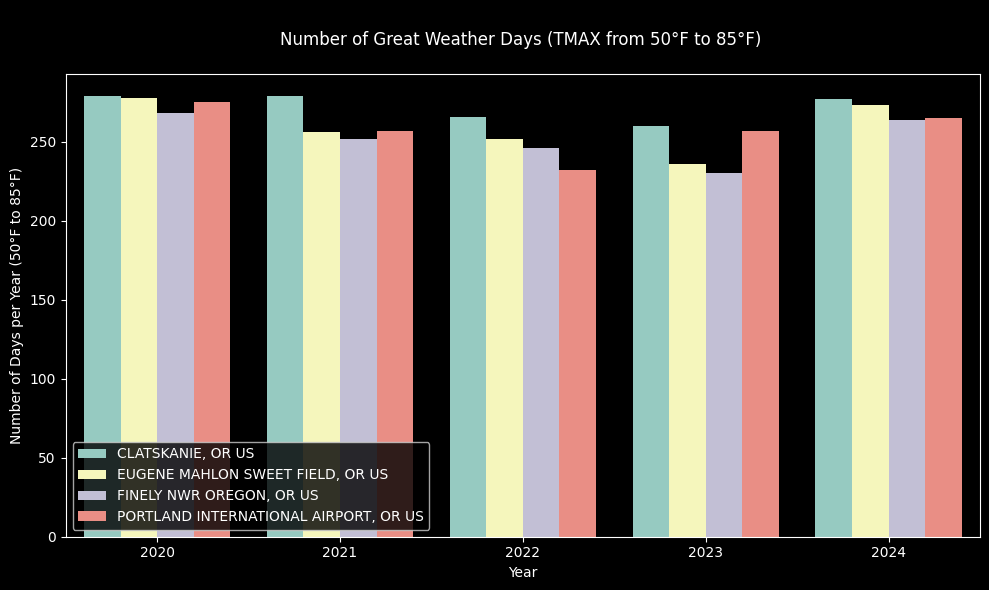

,ideal_days
NAME,
"CLATSKANIE, OR US",272.2
"EUGENE MAHLON SWEET FIELD, OR US",259.0
"PORTLAND INTERNATIONAL AIRPORT, OR US",257.2
"FINELY NWR OREGON, OR US",252.0


In [9]:
# Great Days
p, avg_great_days = functions.ideal_temp(df, 'TMAX', 50, 85)
avg_great_days.sort_values(by='ideal_days', ascending=False)

In [11]:
# Ideal Temperature Summary
def non_ideal_temp_days(df, tmin_threshold, tmax_threshold):
    """
    Calculate the average annual number of non-ideal temperature days for each location.

    Args:
        df (pd.DataFrame): DataFrame with temperature data
        tmin_threshold (float): Maximum temperature threshold for too cold days
        tmax_threshold (float): Minimum temperature threshold for too hot days
    
    Returns:
        pd.DataFrame: DataFrame with average annual non-ideal temperature days for each location.
    """
    # too_cold
    too_cold = df[(df['TMIN'] <= tmin_threshold)]
    too_cold_yearly = too_cold.groupby(["NAME", "year"], as_index=False).agg({"DATE": "count"})
    too_cold_yearly_avg = too_cold_yearly.groupby(["NAME"], as_index=False).agg({"DATE": "mean"})
    too_cold_yearly_avg = too_cold_yearly_avg.rename(columns={"DATE": "avg_days_too_cold"})

    # too_hot
    too_hot = df[df['TMAX'] >= tmax_threshold]
    too_hot_yearly = too_hot.groupby(["NAME", "year"], as_index=False).agg({"DATE": "count"})
    too_hot_yearly_avg = too_hot_yearly.groupby(["NAME"], as_index=False).agg({"DATE": "mean"})
    too_hot_yearly_avg = too_hot_yearly_avg.rename(columns={"DATE": "avg_days_too_hot"})

    too = too_cold_yearly_avg.merge(
        too_hot_yearly_avg,
        on=["NAME"],
        how="inner",
    )
    too['non_ideal_days'] = round(too['avg_days_too_cold'] + too['avg_days_too_hot'], 0)
    return too.sort_values(by='non_ideal_days')

In [18]:
non = non_ideal_temp_days(df, tmin_threshold=32, tmax_threshold=85)
non

,NAME,avg_days_too_cold,avg_days_too_hot,non_ideal_days
3,"PORTLAND INTERNATIONAL AIRPORT, OR US",24.6,50.8,75.0
0,"CLATSKANIE, OR US",65.6,15.4,81.0
2,"FINELY NWR OREGON, OR US",53.0,52.0,105.0
1,"EUGENE MAHLON SWEET FIELD, OR US",48.0,57.6,106.0


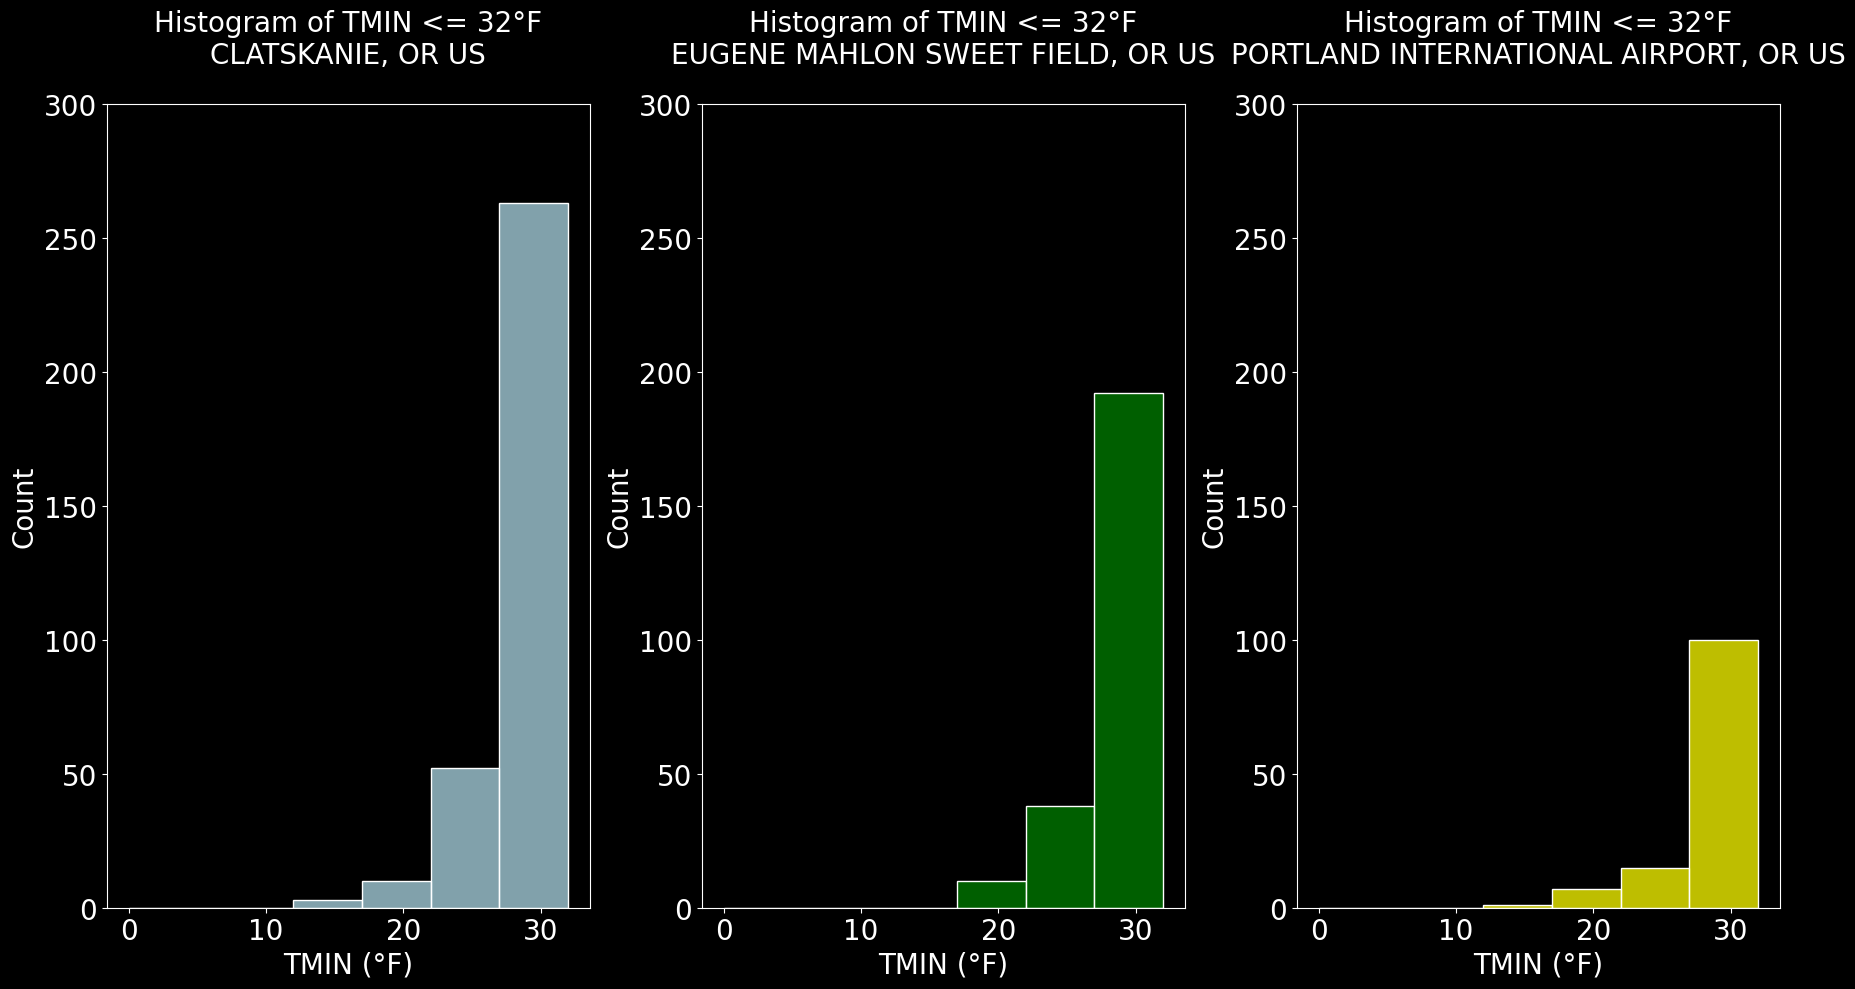

In [54]:
# show the three histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
y_lim = (0, 300)
tmin_max = 32
font_size = 20
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'CLATSKANIE, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='lightblue',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[0])
axs[0].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[0].set_xlabel('TMIN (°F)')
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'EUGENE MAHLON SWEET FIELD, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='green',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[1])
axs[1].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[1].set_xlabel('TMIN (°F)')
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'PORTLAND INTERNATIONAL AIRPORT, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='yellow',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[2])
axs[2].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[2].set_xlabel('TMIN (°F)')
# increase the label font size
for ax in axs:
    ax.title.set_fontsize(font_size)
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)
    # increase the tick font size
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_ylim(y_lim)
plt.tight_layout()
plt.show()

In [53]:
# # Create a histogram of avg_days_too_cold, filter df on the same threshold and
# tmin_max = 32
# location = 'PORTLAND INTERNATIONAL AIRPORT, OR US'
# plot_df = df[df['NAME']==location]

# sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
#     x="TMIN", 
#     color='yellow',
#     bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max])
# plt.title(f'Distribution of TMIN <= {tmin_max}°F')
# plt.suptitle(f'{location}')
# plt.xlabel('TMIN (°F)')
# plt.ylabel('Count of Days')
# plt.show()

In [55]:
non_ideal_temp_days(df, tmin_threshold=35, tmax_threshold=85)
# 32 to 35, there's 40 more days in Clatskanie
# it would be helpful to show a histogram along with this table

,NAME,avg_days_too_cold,avg_days_too_hot,non_ideal_days
3,"PORTLAND INTERNATIONAL AIRPORT, OR US",46.2,50.8,97.0
0,"CLATSKANIE, OR US",100.6,15.4,116.0
1,"EUGENE MAHLON SWEET FIELD, OR US",83.2,57.6,141.0
2,"FINELY NWR OREGON, OR US",89.2,52.0,141.0


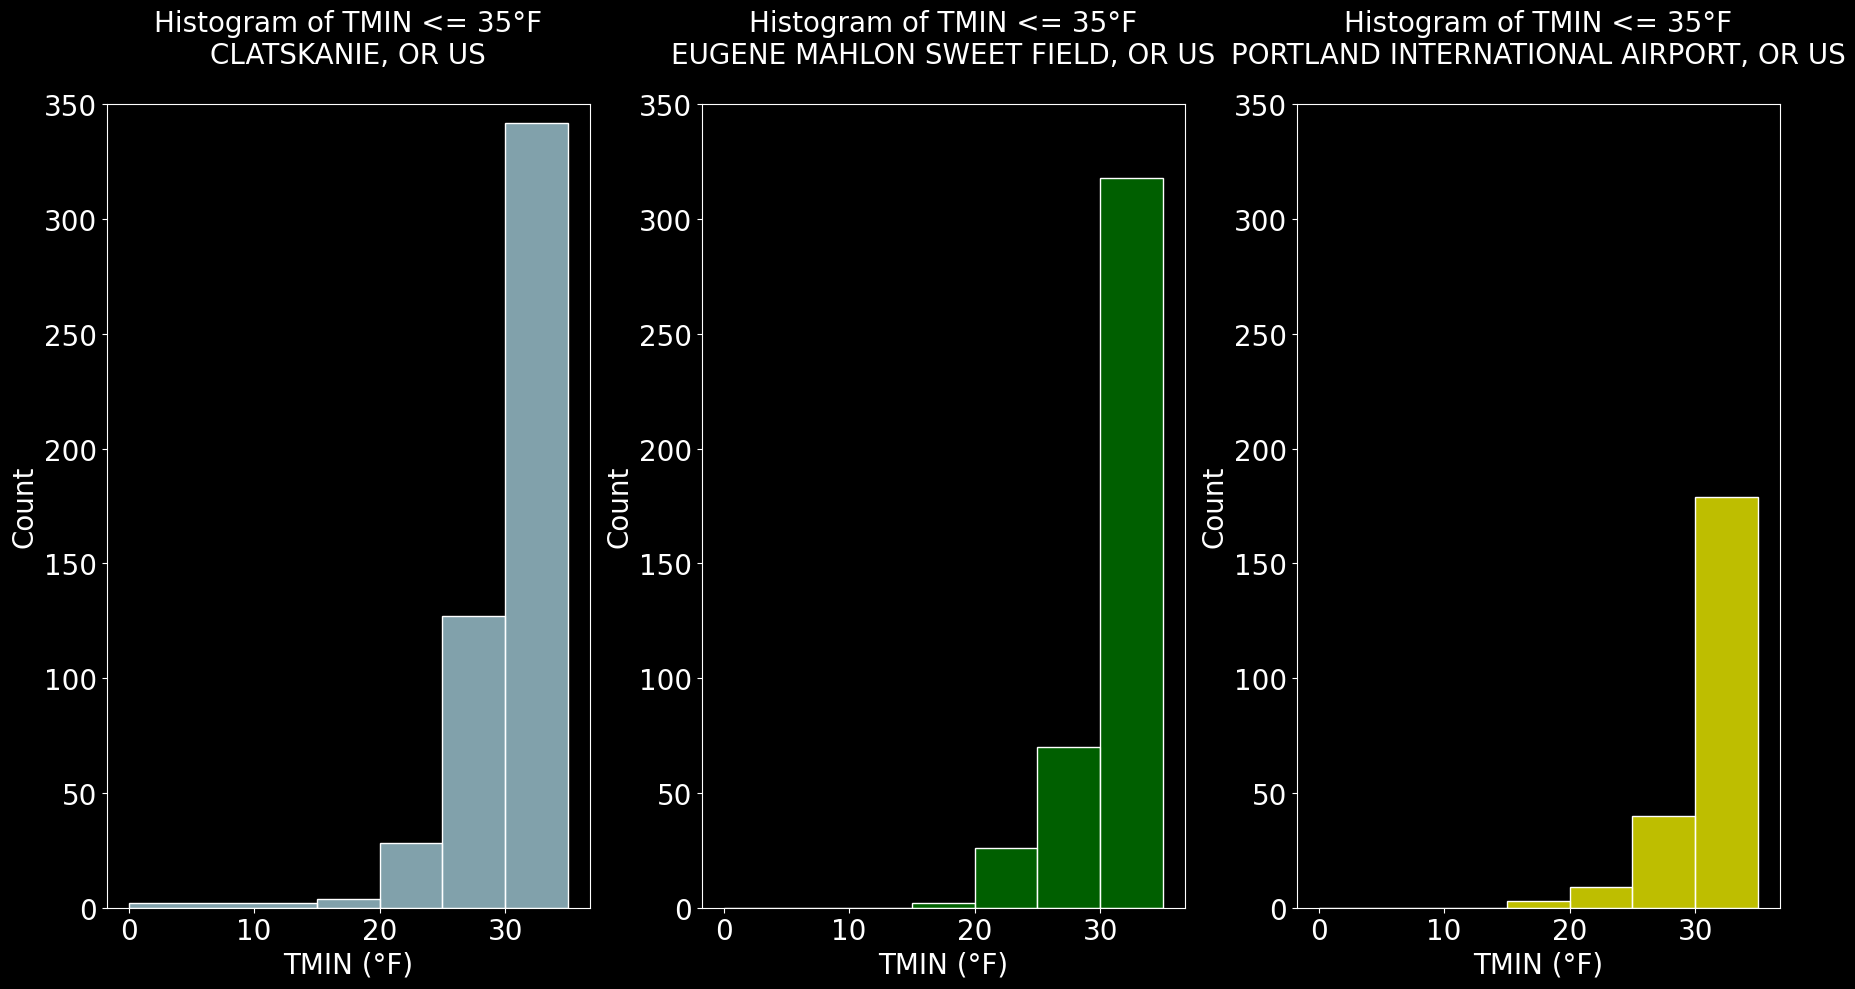

In [57]:
# show the three histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
y_lim = (0, 350)
tmin_max = 35
font_size = 20
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'CLATSKANIE, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='lightblue',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[0])
axs[0].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[0].set_xlabel('TMIN (°F)')
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'EUGENE MAHLON SWEET FIELD, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='green',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[1])
axs[1].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[1].set_xlabel('TMIN (°F)')
# Create a histogram of avg_days_too_cold, filter df on the same threshold and
location = 'PORTLAND INTERNATIONAL AIRPORT, OR US'
plot_df = df[df['NAME']==location]
sns.histplot(data=plot_df[plot_df['TMIN']<=tmin_max], 
             x='TMIN', 
             color='yellow',
             bins=[0, tmin_max-20, tmin_max-15, tmin_max-10, tmin_max-5, tmin_max],
             ax=axs[2])
axs[2].set_title(f'Histogram of TMIN <= {tmin_max}°F\n{location}\n')
axs[2].set_xlabel('TMIN (°F)')
# increase the label font size
for ax in axs:
    ax.title.set_fontsize(font_size)
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)
    # increase the tick font size
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_ylim(y_lim)
plt.tight_layout()
plt.show()

In [ ]:
df[(df['NAME']=='CLATSKANIE, OR US')
   & (df['TMIN']<=35) & (df['TMIN']>30)
   ]

,DATE,year,NAME,TMAX,TMIN
56188,2020-01-04,2020,"CLATSKANIE, OR US",53.0,35.0
56193,2020-01-09,2020,"CLATSKANIE, OR US",43.0,32.0
56194,2020-01-10,2020,"CLATSKANIE, OR US",42.0,34.0
56195,2020-01-11,2020,"CLATSKANIE, OR US",46.0,34.0
56197,2020-01-13,2020,"CLATSKANIE, OR US",42.0,34.0
...,...,...,...,...,...
57980,2024-11-30,2024,"CLATSKANIE, OR US",46.0,33.0
57992,2024-12-12,2024,"CLATSKANIE, OR US",44.0,32.0
57995,2024-12-15,2024,"CLATSKANIE, OR US",49.0,32.0
58005,2024-12-25,2024,"CLATSKANIE, OR US",51.0,34.0


In [17]:
non_ideal_temp_days(df, tmin_threshold=40, tmax_threshold=85)

,NAME,avg_days_too_cold,avg_days_too_hot,non_ideal_days
3,"PORTLAND INTERNATIONAL AIRPORT, OR US",102.4,50.8,153.0
0,"CLATSKANIE, OR US",159.6,15.4,175.0
1,"EUGENE MAHLON SWEET FIELD, OR US",143.0,57.6,201.0
2,"FINELY NWR OREGON, OR US",150.8,52.0,203.0
